In [6]:
import cv2
import numpy as np
from PIL import Image

def scale_radius(img, scale=300):
    x = img[img.shape[0] // 2, :, :].sum(1)
    r = (x > x.mean() / 10).sum() / 2
    if r == 0:
        r = 1e-5  # Prevent divide-by-zero
    s = scale * 1.0 / r
    return cv2.resize(img, (0, 0), fx=s, fy=s)


def gaussian_subtractive_normalization(img, scale=300):
    img = np.array(img)  # Convert PIL Image to NumPy array
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR) 

    # Step 1: Scale to standard radius
    img = scale_radius(img, scale)

    # Step 2: Subtract local average color
    blur = cv2.GaussianBlur(img, (0, 0), scale / 30)
    img = cv2.addWeighted(img, 4, blur, -4, 128)

    # Step 3: Mask out outer region
    mask = np.zeros(img.shape, dtype=np.uint8)
    center = (img.shape[1] // 2, img.shape[0] // 2)
    radius = int(scale * 0.9)
    cv2.circle(mask, center, radius, (1, 1, 1), -1, lineType=8)
    img = img * mask + 128 * (1 - mask)

    # Convert back to PIL
    return Image.fromarray(img)


def clahe_green_channel(img, use_median_blur=True):
    # Convert PIL to numpy
    img = np.array(img)

    # Select Green Channel
    green_img = img[:, :, 1]

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(green_img)

    # Optional Blur (Gaussian by default)
    if use_median_blur:
        img_blur = cv2.medianBlur(img_clahe, 3)
    else:
        img_blur = cv2.GaussianBlur(img_clahe, (3, 3), 0)

    # Convert back to RGB (since the model expects 3 channels)
    img_rgb = cv2.cvtColor(img_blur, cv2.COLOR_GRAY2RGB)

    # Convert back to PIL
    return Image.fromarray(img_rgb)


def clahe_gaussian_blur(img, use_median_blur=False):
    # Convert PIL to numpy
    img = np.array(img)

    # Convert to Grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    img_clahe = clahe.apply(img_gray)

    # Optional Blur (Gaussian by default)
    if use_median_blur:
        img_blur = cv2.medianBlur(img_clahe, 3)
    else:
        img_blur = cv2.GaussianBlur(img_clahe, (3, 3), 0)

    # Convert back to RGB (since the model expects 3 channels)
    img_rgb = cv2.cvtColor(img_blur, cv2.COLOR_GRAY2RGB)

    # Convert back to PIL
    return Image.fromarray(img_rgb)


def hist_equalization_median_blur(img, use_median_blur=True):
    # Convert PIL to numpy
    img = np.array(img)

    # Convert to Grayscale (Histogram Equalization works on single-channel images)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply Histogram Equalization
    img_eq = cv2.equalizeHist(img_gray)

    # Apply Blur (Median by default)
    if use_median_blur:
        img_blur = cv2.medianBlur(img_eq, 3)
    else:
        img_blur = cv2.GaussianBlur(img_eq, (3, 3), 0)

    # Convert back to RGB (since the model expects 3 channels)
    img_rgb = cv2.cvtColor(img_blur, cv2.COLOR_GRAY2RGB)

    # Convert back to PIL
    return Image.fromarray(img_rgb)




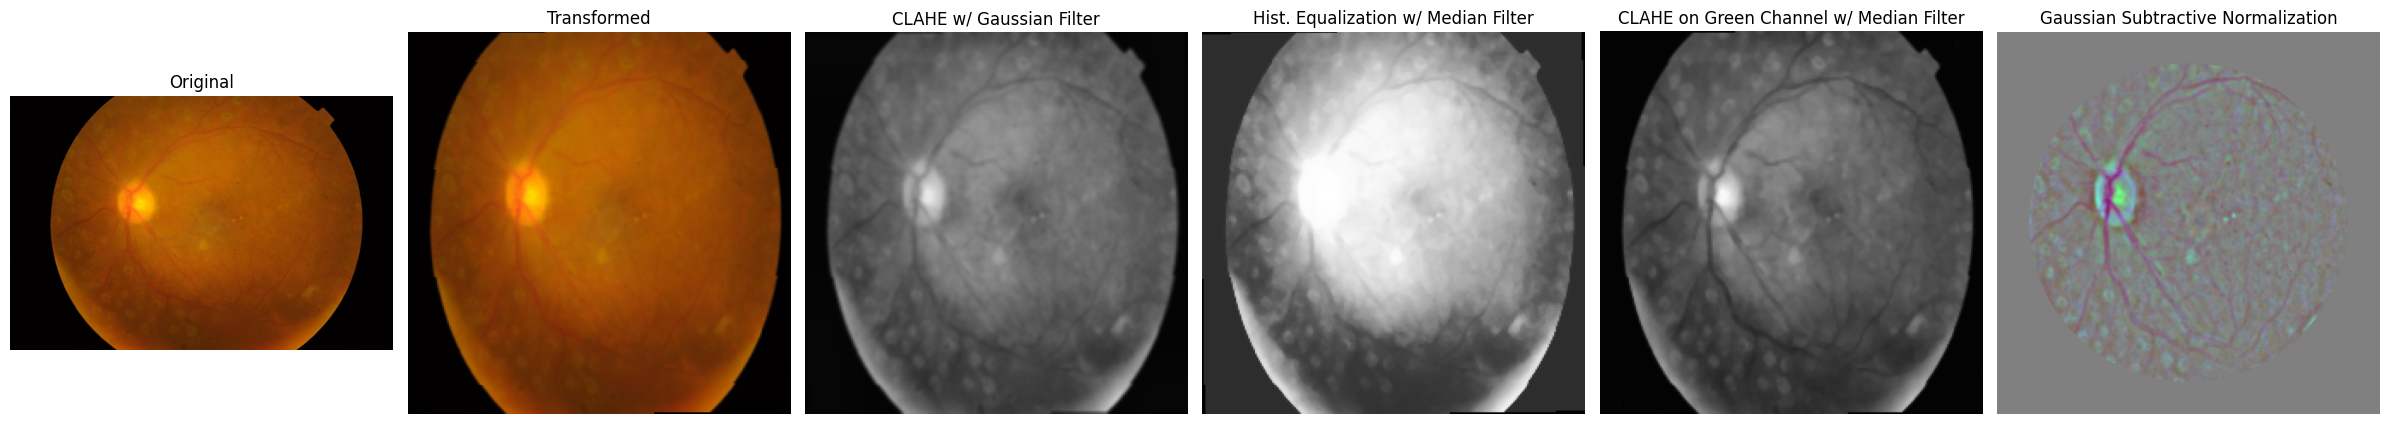

In [7]:
from torchvision import transforms
import matplotlib.pyplot as plt
import torch

# Define ImageNet normalization values
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Define train transforms (without Normalize to preserve visibility)
train_transforms = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
])

# Load the original image
image_path = "data/aptos2019/train_images/10fca1abf338.png"
original_image = Image.open(image_path).convert("RGB")

# Apply the transform
transformed_image = train_transforms(original_image)

# Preprocess functions applied to the transformed image
prep_1 = clahe_gaussian_blur(transformed_image)
prep_2 = hist_equalization_median_blur(transformed_image)
prep_3 = clahe_green_channel(transformed_image)
prep_4 = gaussian_subtractive_normalization(transformed_image)

# Collect images and titles
images = [
    original_image,
    transformed_image,
    prep_1,
    prep_2,
    prep_3,
    prep_4
]

titles = [
    "Original",
    "Transformed",
    "CLAHE w/ Gaussian Filter", 
    "Hist. Equalization w/ Median Filter", 
    "CLAHE on Green Channel w/ Median Filter", 
    "Gaussian Subtractive Normalization"
]

# Plot all 6 images
fig, axs = plt.subplots(1, 6, figsize=(24, 5))
for i, ax in enumerate(axs):
    img = images[i]
    if isinstance(img, torch.Tensor):
        img = img.permute(1, 2, 0).numpy()
        img = np.clip(img, 0, 1)
    ax.imshow(img)
    ax.set_title(titles[i], fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()
